In [ ]:
!pip install detectors

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[35]:


# pip install torch torchvision numpy matplotlib
import torch
import torchvision
from torch import nn
import torch.nn.functional as func
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

get_ipython().run_line_magic('matplotlib', 'inline')
import detectors
import timm

In [ ]:
model = timm.create_model("resnet18_cifar10", pretrained=True)

In [ ]:
# In[36]:


In [ ]:
# Train transformation
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])
# Test transformation
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
# Download training data from open datasets.
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=train_transform,
)

Files already downloaded and verified


In [ ]:
# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=test_transform,
)

Files already downloaded and verified


In [ ]:
# In[37]:


In [ ]:
# Training batch size
batch_size = 256

In [ ]:
# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15, 15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
# In[38]:


In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [ ]:
# In[39]:


In [ ]:
''' # Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        # print(x.shape)
        x = self.flatten(x)
        # print(x.shape)
        logits = self.linear_relu_stack(x)
        return logits '''

In [ ]:
''' # Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # self.flatten = nn.Flatten()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 7, 2, 2),
            nn.ReLU(),
            nn.Conv2d(64, 256, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(256, 1024, 3, 2, 1),
            nn.ReLU(),
        )
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(1024, 1024)
        self.linear2 = nn.Linear(1024, 10)
        nn.init.kaiming_uniform_(self.linear1.weight)
        nn.init.kaiming_uniform_(self.linear2.weight)

    def forward(self, x):
        # print(x.shape)
        x = self.conv(x)
        x = self.gap(x)
        x = self.flatten(x)
        # print(x.shape)
        x = self.linear1(x)
        logits = self.linear2(x)
        return logits '''

In [ ]:
model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_

In [ ]:
# In[40]:


In [ ]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# SGD Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1.5e-1)

In [ ]:
# In[41]:


In [ ]:
# Training function
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    # Turn on training mode
    model.train()
    train_loss, correct = 0, 0
    for X, y in tqdm(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error

        # print(X.shape, y.shape)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record loss
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= len(dataloader)
    correct /= size

    print(f" Train accuracy: {(100 * correct):>0.1f}%, Avg loss: {train_loss:>8f}")
    return train_loss, correct

In [ ]:
# In[42]:


In [ ]:
# Test function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    # Turn on evalution mode
    model.eval()
    test_loss, correct = 0, 0

    # Turn off gradient descent
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)

            # record loss
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size

    print(f" Test accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return test_loss, correct

In [ ]:
# In[49]:


In [ ]:
# Total training epochs
epochs = 100
training_losses = []
testing_losses = []
training_accuracy = []
testing_accuracy = []
for t in range(epochs):
    print('\n', "=" * 15, "Epoch", t + 1, "=" * 15)
    train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_accuracy = test(test_dataloader, model, loss_fn)
    training_losses.append(train_loss)
    testing_losses.append(test_loss)
    training_accuracy.append(train_accuracy)
    testing_accuracy.append(test_accuracy)


 =============== Epoch 1 ===============


100%|██████████| 196/196 [00:56<00:00,  3.50it/s]


 Train accuracy: 99.7%, Avg loss: 0.011057


100%|██████████| 40/40 [00:03<00:00, 10.92it/s]


 Test accuracy: 90.4%, Avg loss: 0.406579

 =============== Epoch 2 ===============


100%|██████████| 196/196 [00:55<00:00,  3.53it/s]


 Train accuracy: 99.1%, Avg loss: 0.027211


100%|██████████| 40/40 [00:03<00:00, 10.72it/s]


 Test accuracy: 91.8%, Avg loss: 0.374753

 =============== Epoch 3 ===============


100%|██████████| 196/196 [00:55<00:00,  3.56it/s]


 Train accuracy: 99.4%, Avg loss: 0.020497


100%|██████████| 40/40 [00:04<00:00,  9.65it/s]


 Test accuracy: 92.5%, Avg loss: 0.301204

 =============== Epoch 4 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 99.4%, Avg loss: 0.017666


100%|██████████| 40/40 [00:03<00:00, 10.88it/s]


 Test accuracy: 93.3%, Avg loss: 0.290733

 =============== Epoch 5 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 99.6%, Avg loss: 0.013681


100%|██████████| 40/40 [00:03<00:00, 10.72it/s]


 Test accuracy: 92.8%, Avg loss: 0.305846

 =============== Epoch 6 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 99.5%, Avg loss: 0.014046


100%|██████████| 40/40 [00:04<00:00,  9.65it/s]


 Test accuracy: 90.7%, Avg loss: 0.452160

 =============== Epoch 7 ===============


100%|██████████| 196/196 [00:54<00:00,  3.59it/s]


 Train accuracy: 99.5%, Avg loss: 0.015014


100%|██████████| 40/40 [00:03<00:00, 10.89it/s]


 Test accuracy: 93.0%, Avg loss: 0.291386

 =============== Epoch 8 ===============


100%|██████████| 196/196 [00:54<00:00,  3.59it/s]


 Train accuracy: 99.8%, Avg loss: 0.008402


100%|██████████| 40/40 [00:03<00:00, 10.79it/s]


 Test accuracy: 92.3%, Avg loss: 0.334984

 =============== Epoch 9 ===============


100%|██████████| 196/196 [00:54<00:00,  3.59it/s]


 Train accuracy: 99.7%, Avg loss: 0.010161


100%|██████████| 40/40 [00:04<00:00,  9.59it/s]


 Test accuracy: 93.2%, Avg loss: 0.313270

 =============== Epoch 10 ===============


100%|██████████| 196/196 [00:54<00:00,  3.59it/s]


 Train accuracy: 99.8%, Avg loss: 0.007491


100%|██████████| 40/40 [00:03<00:00, 10.63it/s]


 Test accuracy: 93.2%, Avg loss: 0.301072

 =============== Epoch 11 ===============


100%|██████████| 196/196 [00:55<00:00,  3.55it/s]


 Train accuracy: 99.7%, Avg loss: 0.009480


100%|██████████| 40/40 [00:03<00:00, 10.80it/s]


 Test accuracy: 93.0%, Avg loss: 0.327863

 =============== Epoch 12 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 99.8%, Avg loss: 0.007375


100%|██████████| 40/40 [00:04<00:00,  9.66it/s]


 Test accuracy: 93.6%, Avg loss: 0.301710

 =============== Epoch 13 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 99.8%, Avg loss: 0.007881


100%|██████████| 40/40 [00:03<00:00, 10.53it/s]


 Test accuracy: 93.7%, Avg loss: 0.302585

 =============== Epoch 14 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 99.7%, Avg loss: 0.010699


100%|██████████| 40/40 [00:03<00:00, 10.82it/s]


 Test accuracy: 93.0%, Avg loss: 0.326360

 =============== Epoch 15 ===============


100%|██████████| 196/196 [00:55<00:00,  3.55it/s]


 Train accuracy: 99.6%, Avg loss: 0.011404


100%|██████████| 40/40 [00:04<00:00,  9.52it/s]


 Test accuracy: 93.4%, Avg loss: 0.313714

 =============== Epoch 16 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 99.8%, Avg loss: 0.006180


100%|██████████| 40/40 [00:03<00:00, 10.61it/s]


 Test accuracy: 93.7%, Avg loss: 0.283759

 =============== Epoch 17 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 99.8%, Avg loss: 0.006237


100%|██████████| 40/40 [00:03<00:00, 10.78it/s]


 Test accuracy: 93.2%, Avg loss: 0.315411

 =============== Epoch 18 ===============


100%|██████████| 196/196 [00:55<00:00,  3.55it/s]


 Train accuracy: 99.7%, Avg loss: 0.009214


100%|██████████| 40/40 [00:04<00:00,  9.50it/s]


 Test accuracy: 93.2%, Avg loss: 0.321627

 =============== Epoch 19 ===============


100%|██████████| 196/196 [00:55<00:00,  3.56it/s]


 Train accuracy: 99.8%, Avg loss: 0.007244


100%|██████████| 40/40 [00:03<00:00, 10.60it/s]


 Test accuracy: 93.8%, Avg loss: 0.291942

 =============== Epoch 20 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 99.8%, Avg loss: 0.006190


100%|██████████| 40/40 [00:03<00:00, 10.87it/s]


 Test accuracy: 90.7%, Avg loss: 0.525889

 =============== Epoch 21 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 99.8%, Avg loss: 0.007688


100%|██████████| 40/40 [00:04<00:00,  9.59it/s]


 Test accuracy: 92.9%, Avg loss: 0.360481

 =============== Epoch 22 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 99.8%, Avg loss: 0.006387


100%|██████████| 40/40 [00:03<00:00, 10.90it/s]


 Test accuracy: 93.3%, Avg loss: 0.318962

 =============== Epoch 23 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 99.8%, Avg loss: 0.005434


100%|██████████| 40/40 [00:03<00:00, 10.80it/s]


 Test accuracy: 93.5%, Avg loss: 0.313099

 =============== Epoch 24 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 99.8%, Avg loss: 0.006327


100%|██████████| 40/40 [00:04<00:00,  9.56it/s]


 Test accuracy: 93.9%, Avg loss: 0.298236

 =============== Epoch 25 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 99.8%, Avg loss: 0.004915


100%|██████████| 40/40 [00:03<00:00, 10.75it/s]


 Test accuracy: 93.8%, Avg loss: 0.319001

 =============== Epoch 26 ===============


100%|██████████| 196/196 [00:55<00:00,  3.56it/s]


 Train accuracy: 99.8%, Avg loss: 0.007116


100%|██████████| 40/40 [00:03<00:00, 10.78it/s]


 Test accuracy: 93.4%, Avg loss: 0.319164

 =============== Epoch 27 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 99.9%, Avg loss: 0.004586


100%|██████████| 40/40 [00:03<00:00, 10.26it/s]


 Test accuracy: 93.8%, Avg loss: 0.306386

 =============== Epoch 28 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 99.9%, Avg loss: 0.003287


100%|██████████| 40/40 [00:03<00:00, 10.10it/s]


 Test accuracy: 93.6%, Avg loss: 0.316968

 =============== Epoch 29 ===============


100%|██████████| 196/196 [00:54<00:00,  3.59it/s]


 Train accuracy: 99.9%, Avg loss: 0.003327


100%|██████████| 40/40 [00:03<00:00, 10.72it/s]


 Test accuracy: 94.2%, Avg loss: 0.294678

 =============== Epoch 30 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 99.9%, Avg loss: 0.002977


100%|██████████| 40/40 [00:03<00:00, 10.12it/s]


 Test accuracy: 94.0%, Avg loss: 0.302334

 =============== Epoch 31 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 99.9%, Avg loss: 0.002139


100%|██████████| 40/40 [00:03<00:00, 10.11it/s]


 Test accuracy: 94.0%, Avg loss: 0.314053

 =============== Epoch 32 ===============


100%|██████████| 196/196 [00:54<00:00,  3.59it/s]


 Train accuracy: 99.9%, Avg loss: 0.003355


100%|██████████| 40/40 [00:03<00:00, 10.76it/s]


 Test accuracy: 93.8%, Avg loss: 0.322483

 =============== Epoch 33 ===============


100%|██████████| 196/196 [00:55<00:00,  3.56it/s]


 Train accuracy: 99.9%, Avg loss: 0.004178


100%|██████████| 40/40 [00:03<00:00, 10.30it/s]


 Test accuracy: 93.7%, Avg loss: 0.328661

 =============== Epoch 34 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 99.8%, Avg loss: 0.005322


100%|██████████| 40/40 [00:03<00:00, 10.10it/s]


 Test accuracy: 93.5%, Avg loss: 0.331245

 =============== Epoch 35 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 99.9%, Avg loss: 0.004637


100%|██████████| 40/40 [00:03<00:00, 10.77it/s]


 Test accuracy: 93.2%, Avg loss: 0.346144

 =============== Epoch 36 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 99.9%, Avg loss: 0.003493


100%|██████████| 40/40 [00:03<00:00, 10.11it/s]


 Test accuracy: 93.6%, Avg loss: 0.320933

 =============== Epoch 37 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 99.9%, Avg loss: 0.003040


100%|██████████| 40/40 [00:03<00:00, 10.17it/s]


 Test accuracy: 94.0%, Avg loss: 0.316860

 =============== Epoch 38 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 99.9%, Avg loss: 0.002877


100%|██████████| 40/40 [00:03<00:00, 10.82it/s]


 Test accuracy: 94.0%, Avg loss: 0.301783

 =============== Epoch 39 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 99.9%, Avg loss: 0.002091


100%|██████████| 40/40 [00:03<00:00, 10.12it/s]


 Test accuracy: 94.2%, Avg loss: 0.295469

 =============== Epoch 40 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 100.0%, Avg loss: 0.001576


100%|██████████| 40/40 [00:03<00:00, 10.10it/s]


 Test accuracy: 93.8%, Avg loss: 0.306877

 =============== Epoch 41 ===============


100%|██████████| 196/196 [00:55<00:00,  3.55it/s]


 Train accuracy: 99.9%, Avg loss: 0.001829


100%|██████████| 40/40 [00:03<00:00, 10.75it/s]


 Test accuracy: 94.2%, Avg loss: 0.297547

 =============== Epoch 42 ===============


100%|██████████| 196/196 [00:55<00:00,  3.56it/s]


 Train accuracy: 99.8%, Avg loss: 0.004455


100%|██████████| 40/40 [00:03<00:00, 10.12it/s]


 Test accuracy: 93.6%, Avg loss: 0.336765

 =============== Epoch 43 ===============


100%|██████████| 196/196 [00:55<00:00,  3.56it/s]


 Train accuracy: 99.8%, Avg loss: 0.005081


100%|██████████| 40/40 [00:03<00:00, 10.03it/s]


 Test accuracy: 93.9%, Avg loss: 0.305121

 =============== Epoch 44 ===============


100%|██████████| 196/196 [00:55<00:00,  3.56it/s]


 Train accuracy: 99.9%, Avg loss: 0.003913


100%|██████████| 40/40 [00:03<00:00, 10.83it/s]


 Test accuracy: 93.7%, Avg loss: 0.323518

 =============== Epoch 45 ===============


100%|██████████| 196/196 [00:54<00:00,  3.56it/s]


 Train accuracy: 99.8%, Avg loss: 0.004403


100%|██████████| 40/40 [00:03<00:00, 10.14it/s]


 Test accuracy: 93.7%, Avg loss: 0.325152

 =============== Epoch 46 ===============


100%|██████████| 196/196 [00:54<00:00,  3.56it/s]


 Train accuracy: 99.8%, Avg loss: 0.005181


100%|██████████| 40/40 [00:03<00:00, 10.29it/s]


 Test accuracy: 93.4%, Avg loss: 0.337075

 =============== Epoch 47 ===============


100%|██████████| 196/196 [00:54<00:00,  3.56it/s]


 Train accuracy: 99.9%, Avg loss: 0.003906


100%|██████████| 40/40 [00:03<00:00, 10.68it/s]


 Test accuracy: 93.8%, Avg loss: 0.333959

 =============== Epoch 48 ===============


100%|██████████| 196/196 [00:58<00:00,  3.36it/s]


 Train accuracy: 99.9%, Avg loss: 0.002204


100%|██████████| 40/40 [00:06<00:00,  6.22it/s]


 Test accuracy: 92.5%, Avg loss: 0.411284

 =============== Epoch 49 ===============


100%|██████████| 196/196 [00:57<00:00,  3.41it/s]


 Train accuracy: 99.9%, Avg loss: 0.002982


100%|██████████| 40/40 [00:03<00:00, 10.70it/s]


 Test accuracy: 93.6%, Avg loss: 0.323355

 =============== Epoch 50 ===============


100%|██████████| 196/196 [00:56<00:00,  3.49it/s]


 Train accuracy: 99.9%, Avg loss: 0.002811


100%|██████████| 40/40 [00:04<00:00,  9.35it/s]


 Test accuracy: 94.3%, Avg loss: 0.308551

 =============== Epoch 51 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 99.9%, Avg loss: 0.002970


100%|██████████| 40/40 [00:03<00:00, 10.71it/s]


 Test accuracy: 93.8%, Avg loss: 0.334520

 =============== Epoch 52 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 99.9%, Avg loss: 0.001962


100%|██████████| 40/40 [00:03<00:00, 10.74it/s]


 Test accuracy: 93.9%, Avg loss: 0.308421

 =============== Epoch 53 ===============


100%|██████████| 196/196 [00:55<00:00,  3.56it/s]


 Train accuracy: 100.0%, Avg loss: 0.001666


100%|██████████| 40/40 [00:04<00:00,  9.47it/s]


 Test accuracy: 94.0%, Avg loss: 0.338124

 =============== Epoch 54 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 99.9%, Avg loss: 0.003267


100%|██████████| 40/40 [00:03<00:00, 10.73it/s]


 Test accuracy: 89.9%, Avg loss: 0.666008

 =============== Epoch 55 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 99.9%, Avg loss: 0.004601


100%|██████████| 40/40 [00:03<00:00, 10.74it/s]


 Test accuracy: 92.4%, Avg loss: 0.429569

 =============== Epoch 56 ===============


100%|██████████| 196/196 [00:55<00:00,  3.56it/s]


 Train accuracy: 99.9%, Avg loss: 0.004074


100%|██████████| 40/40 [00:04<00:00,  9.62it/s]


 Test accuracy: 93.5%, Avg loss: 0.345250

 =============== Epoch 57 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 99.8%, Avg loss: 0.004573


100%|██████████| 40/40 [00:03<00:00, 10.47it/s]


 Test accuracy: 93.2%, Avg loss: 0.364143

 =============== Epoch 58 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 99.9%, Avg loss: 0.002715


100%|██████████| 40/40 [00:03<00:00, 10.45it/s]


 Test accuracy: 94.0%, Avg loss: 0.332086

 =============== Epoch 59 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 100.0%, Avg loss: 0.001840


100%|██████████| 40/40 [00:04<00:00,  9.70it/s]


 Test accuracy: 93.9%, Avg loss: 0.320531

 =============== Epoch 60 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 100.0%, Avg loss: 0.001317


100%|██████████| 40/40 [00:03<00:00, 10.69it/s]


 Test accuracy: 94.3%, Avg loss: 0.314752

 =============== Epoch 61 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 100.0%, Avg loss: 0.000953


100%|██████████| 40/40 [00:03<00:00, 10.35it/s]


 Test accuracy: 94.0%, Avg loss: 0.322863

 =============== Epoch 62 ===============


100%|██████████| 196/196 [00:55<00:00,  3.56it/s]


 Train accuracy: 100.0%, Avg loss: 0.000501


100%|██████████| 40/40 [00:04<00:00,  9.82it/s]


 Test accuracy: 94.1%, Avg loss: 0.315837

 =============== Epoch 63 ===============


100%|██████████| 196/196 [00:55<00:00,  3.56it/s]


 Train accuracy: 100.0%, Avg loss: 0.000832


100%|██████████| 40/40 [00:03<00:00, 10.72it/s]


 Test accuracy: 94.0%, Avg loss: 0.315173

 =============== Epoch 64 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 100.0%, Avg loss: 0.001344


100%|██████████| 40/40 [00:03<00:00, 10.06it/s]


 Test accuracy: 94.1%, Avg loss: 0.331942

 =============== Epoch 65 ===============


100%|██████████| 196/196 [00:55<00:00,  3.56it/s]


 Train accuracy: 99.9%, Avg loss: 0.002462


100%|██████████| 40/40 [00:04<00:00,  9.97it/s]


 Test accuracy: 94.0%, Avg loss: 0.341873

 =============== Epoch 66 ===============


100%|██████████| 196/196 [00:55<00:00,  3.53it/s]


 Train accuracy: 100.0%, Avg loss: 0.001654


100%|██████████| 40/40 [00:03<00:00, 10.66it/s]


 Test accuracy: 93.4%, Avg loss: 0.367452

 =============== Epoch 67 ===============


100%|██████████| 196/196 [00:55<00:00,  3.52it/s]


 Train accuracy: 100.0%, Avg loss: 0.000921


100%|██████████| 40/40 [00:03<00:00, 10.04it/s]


 Test accuracy: 94.0%, Avg loss: 0.348575

 =============== Epoch 68 ===============


100%|██████████| 196/196 [00:55<00:00,  3.52it/s]


 Train accuracy: 100.0%, Avg loss: 0.001519


100%|██████████| 40/40 [00:04<00:00,  9.96it/s]


 Test accuracy: 94.0%, Avg loss: 0.341709

 =============== Epoch 69 ===============


100%|██████████| 196/196 [00:55<00:00,  3.52it/s]


 Train accuracy: 100.0%, Avg loss: 0.001463


100%|██████████| 40/40 [00:03<00:00, 10.57it/s]


 Test accuracy: 94.1%, Avg loss: 0.339289

 =============== Epoch 70 ===============


100%|██████████| 196/196 [00:55<00:00,  3.53it/s]


 Train accuracy: 99.9%, Avg loss: 0.002774


100%|██████████| 40/40 [00:04<00:00,  9.77it/s]


 Test accuracy: 94.1%, Avg loss: 0.360874

 =============== Epoch 71 ===============


100%|██████████| 196/196 [00:55<00:00,  3.50it/s]


 Train accuracy: 99.8%, Avg loss: 0.005614


100%|██████████| 40/40 [00:03<00:00, 10.08it/s]


 Test accuracy: 93.6%, Avg loss: 0.356526

 =============== Epoch 72 ===============


100%|██████████| 196/196 [00:55<00:00,  3.55it/s]


 Train accuracy: 99.9%, Avg loss: 0.002765


100%|██████████| 40/40 [00:03<00:00, 10.72it/s]


 Test accuracy: 93.7%, Avg loss: 0.370900

 =============== Epoch 73 ===============


100%|██████████| 196/196 [00:55<00:00,  3.53it/s]


 Train accuracy: 99.9%, Avg loss: 0.002797


100%|██████████| 40/40 [00:03<00:00, 10.07it/s]


 Test accuracy: 93.8%, Avg loss: 0.343856

 =============== Epoch 74 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 100.0%, Avg loss: 0.001512


100%|██████████| 40/40 [00:03<00:00, 10.04it/s]


 Test accuracy: 94.2%, Avg loss: 0.329868

 =============== Epoch 75 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 100.0%, Avg loss: 0.000546


100%|██████████| 40/40 [00:03<00:00, 10.80it/s]


 Test accuracy: 94.3%, Avg loss: 0.326060

 =============== Epoch 76 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 100.0%, Avg loss: 0.000813


100%|██████████| 40/40 [00:03<00:00, 10.42it/s]


 Test accuracy: 94.1%, Avg loss: 0.336662

 =============== Epoch 77 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 100.0%, Avg loss: 0.000690


100%|██████████| 40/40 [00:04<00:00,  9.75it/s]


 Test accuracy: 94.5%, Avg loss: 0.329898

 =============== Epoch 78 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 100.0%, Avg loss: 0.000277


100%|██████████| 40/40 [00:03<00:00, 10.68it/s]


 Test accuracy: 94.4%, Avg loss: 0.332080

 =============== Epoch 79 ===============


100%|██████████| 196/196 [00:55<00:00,  3.56it/s]


 Train accuracy: 100.0%, Avg loss: 0.000721


100%|██████████| 40/40 [00:03<00:00, 10.29it/s]


 Test accuracy: 94.5%, Avg loss: 0.329377

 =============== Epoch 80 ===============


100%|██████████| 196/196 [00:55<00:00,  3.56it/s]


 Train accuracy: 100.0%, Avg loss: 0.001024


100%|██████████| 40/40 [00:04<00:00,  9.89it/s]


 Test accuracy: 94.0%, Avg loss: 0.353130

 =============== Epoch 81 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 100.0%, Avg loss: 0.001688


100%|██████████| 40/40 [00:03<00:00, 10.71it/s]


 Test accuracy: 93.6%, Avg loss: 0.385986

 =============== Epoch 82 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 100.0%, Avg loss: 0.001379


100%|██████████| 40/40 [00:03<00:00, 10.20it/s]


 Test accuracy: 93.5%, Avg loss: 0.371335

 =============== Epoch 83 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 100.0%, Avg loss: 0.001313


100%|██████████| 40/40 [00:03<00:00, 10.03it/s]


 Test accuracy: 94.2%, Avg loss: 0.335068

 =============== Epoch 84 ===============


100%|██████████| 196/196 [00:56<00:00,  3.45it/s]


 Train accuracy: 100.0%, Avg loss: 0.000354


100%|██████████| 40/40 [00:03<00:00, 10.71it/s]


 Test accuracy: 94.2%, Avg loss: 0.324217

 =============== Epoch 85 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 100.0%, Avg loss: 0.000384


100%|██████████| 40/40 [00:04<00:00,  9.53it/s]


 Test accuracy: 94.1%, Avg loss: 0.329830

 =============== Epoch 86 ===============


100%|██████████| 196/196 [00:55<00:00,  3.56it/s]


 Train accuracy: 100.0%, Avg loss: 0.000290


100%|██████████| 40/40 [00:03<00:00, 10.17it/s]


 Test accuracy: 94.2%, Avg loss: 0.331027

 =============== Epoch 87 ===============


100%|██████████| 196/196 [00:55<00:00,  3.56it/s]


 Train accuracy: 100.0%, Avg loss: 0.000290


100%|██████████| 40/40 [00:03<00:00, 10.66it/s]


 Test accuracy: 94.1%, Avg loss: 0.329084

 =============== Epoch 88 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 100.0%, Avg loss: 0.000423


100%|██████████| 40/40 [00:04<00:00,  9.19it/s]


 Test accuracy: 94.1%, Avg loss: 0.350784

 =============== Epoch 89 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 100.0%, Avg loss: 0.000632


100%|██████████| 40/40 [00:03<00:00, 10.84it/s]


 Test accuracy: 94.3%, Avg loss: 0.339677

 =============== Epoch 90 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 100.0%, Avg loss: 0.000362


100%|██████████| 40/40 [00:03<00:00, 10.78it/s]


 Test accuracy: 93.8%, Avg loss: 0.368309

 =============== Epoch 91 ===============


100%|██████████| 196/196 [00:55<00:00,  3.56it/s]


 Train accuracy: 100.0%, Avg loss: 0.001404


100%|██████████| 40/40 [00:04<00:00,  9.26it/s]


 Test accuracy: 94.0%, Avg loss: 0.357820

 =============== Epoch 92 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 100.0%, Avg loss: 0.000549


100%|██████████| 40/40 [00:03<00:00, 10.70it/s]


 Test accuracy: 94.3%, Avg loss: 0.342288

 =============== Epoch 93 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 100.0%, Avg loss: 0.000205


100%|██████████| 40/40 [00:03<00:00, 10.64it/s]


 Test accuracy: 94.3%, Avg loss: 0.331387

 =============== Epoch 94 ===============


100%|██████████| 196/196 [00:55<00:00,  3.56it/s]


 Train accuracy: 100.0%, Avg loss: 0.000165


100%|██████████| 40/40 [00:04<00:00,  9.36it/s]


 Test accuracy: 94.2%, Avg loss: 0.342068

 =============== Epoch 95 ===============


100%|██████████| 196/196 [00:54<00:00,  3.56it/s]


 Train accuracy: 100.0%, Avg loss: 0.000141


100%|██████████| 40/40 [00:03<00:00, 10.76it/s]


 Test accuracy: 94.3%, Avg loss: 0.335538

 =============== Epoch 96 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 100.0%, Avg loss: 0.000130


100%|██████████| 40/40 [00:03<00:00, 10.65it/s]


 Test accuracy: 94.3%, Avg loss: 0.332999

 =============== Epoch 97 ===============


100%|██████████| 196/196 [00:54<00:00,  3.58it/s]


 Train accuracy: 100.0%, Avg loss: 0.000067


100%|██████████| 40/40 [00:04<00:00,  9.32it/s]


 Test accuracy: 94.3%, Avg loss: 0.330035

 =============== Epoch 98 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 100.0%, Avg loss: 0.000054


100%|██████████| 40/40 [00:03<00:00, 10.83it/s]


 Test accuracy: 94.4%, Avg loss: 0.325314

 =============== Epoch 99 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 100.0%, Avg loss: 0.000056


100%|██████████| 40/40 [00:03<00:00, 10.84it/s]


 Test accuracy: 94.4%, Avg loss: 0.327373

 =============== Epoch 100 ===============


100%|██████████| 196/196 [00:54<00:00,  3.57it/s]


 Train accuracy: 100.0%, Avg loss: 0.000096


100%|██████████| 40/40 [00:04<00:00,  9.49it/s]

 Test accuracy: 94.4%, Avg loss: 0.325708


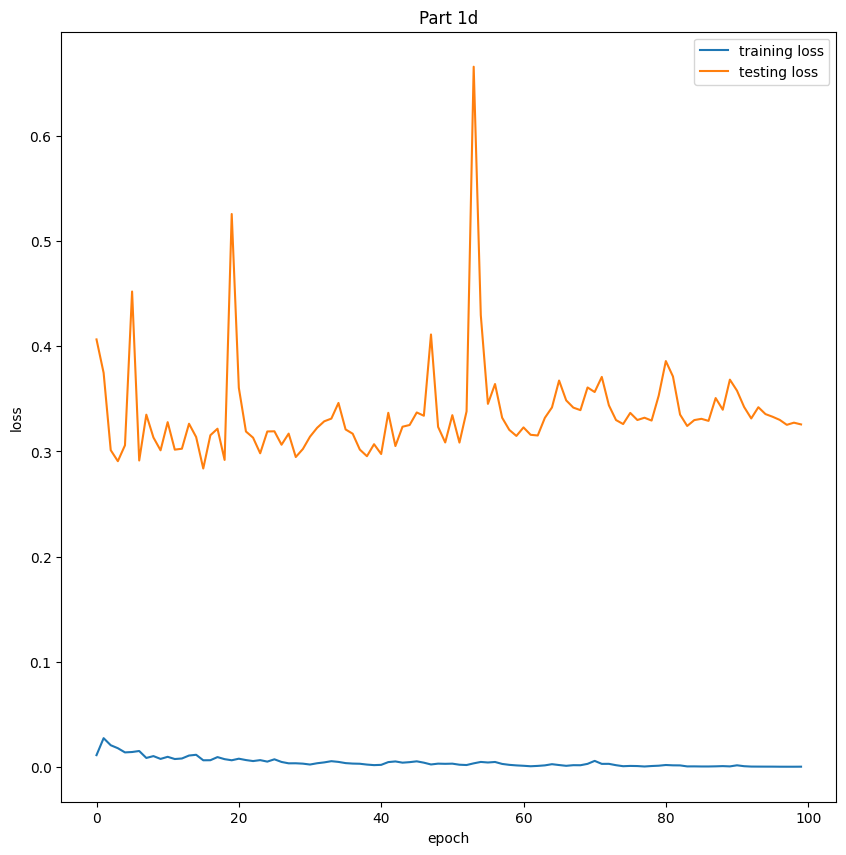

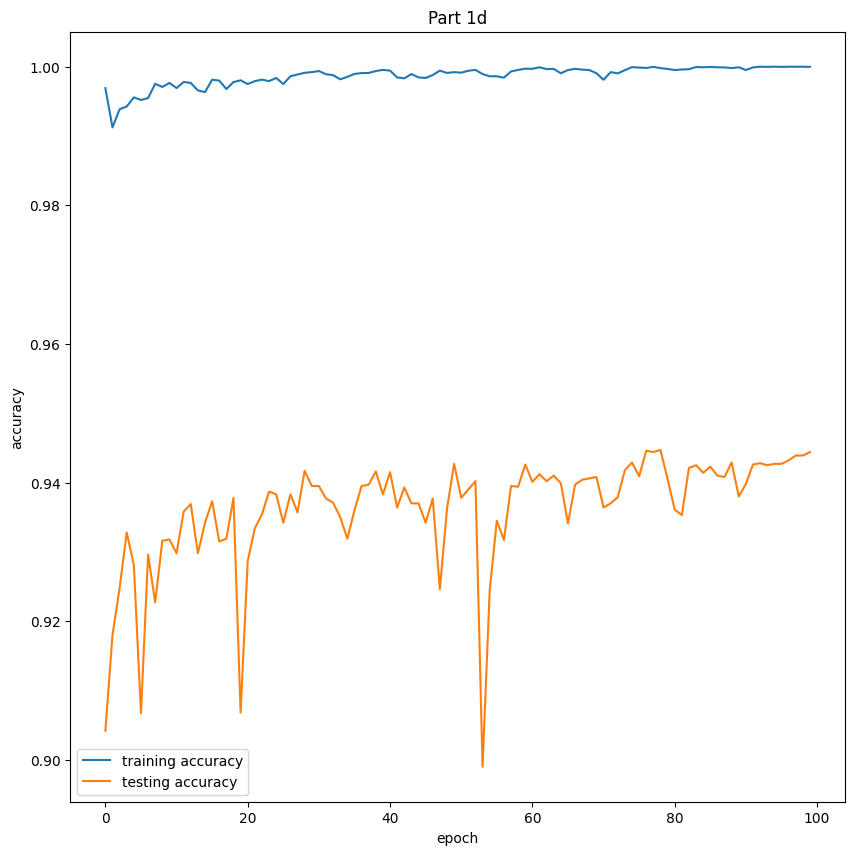

In [ ]:
# Plot the curve of loss and accuracy
plt.figure(figsize=(10, 10))
plt.title("Part 1d")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.plot(training_losses, label='training loss')
plt.plot(testing_losses, label='testing loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 10))
plt.title("Part 1d")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.plot(training_accuracy, label='training accuracy')
plt.plot(testing_accuracy, label='testing accuracy')
plt.legend()
plt.show()